In [30]:
%run ../code/utils.ipynb

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
plt.set_loglevel("warning")

A note on matchup summary data (who played who, total points for each) vs matchup player data (points by position per week per manager):

Playoff weeks can be found in both datasets but in matchup summary data, some data appear missing because they relate to teams who:
- A.) Were disqualified from championship and consolation brackets (13th and 14th place for example)
- B.) Were eliminated from playoff brackets by losing
- C.) Had bye weeks

And therefore there was no corresponding matchup.

On the other hand, their weekly player roster stats were still tracked, meaning there is more weekly data available in matchup player data than in matchup summary data.

**Example:** A team in 14th place in 2023 would not have any matchups beyond week 14 because they did not qualify for any bracket. However, their player stats for weeks 15, 16, and 17 still appear. 

In [32]:
data_dir1 = f"{project_dir}\\data\\matchup_summary\\"
data_dir2 = f"{project_dir}\\data\\matchup_player_data\\"

In [33]:
df = pd.read_csv(data_dir1 + 'to_date_matchup_summaries_tidy.csv')

In [34]:
df.shape

(1932, 14)

In [35]:
df = df[df['manager_name'] != 'unknown']

In [36]:
df.shape

(1932, 14)

In [37]:
df.shape

(1932, 14)

In [38]:
names = list(df['manager_name'].unique())

In [39]:
for name in names:
    df[f"win against {name}"] = 0

In [40]:
wins_df = df[df['win'] == 1 ]

In [41]:
wins_df.reset_index(inplace=True)

In [42]:
for index, name in zip(wins_df.index, wins_df['opponent_name']):
    #wins_df[f"win against {name}"] = 1
    if not name == 'unknown':
        wins_df.iloc[index, wins_df.columns.get_loc(f"win against {name}")] = 1

In [43]:
cat_columns = list(wins_df.columns[-14:])

In [44]:
win_heatmap = wins_df.groupby('manager_name')[cat_columns].sum()

In [45]:
win_heatmap.sort_index(axis=1, inplace=True)

[2024-01-18 17:44:05,625 DEBUG] [matplotlib.colorbar.colorbar._get_ticker_locator_formatter] locator: <matplotlib.ticker.AutoLocator object at 0x0000023FD4DFABD0>
[2024-01-18 17:44:05,625 DEBUG] [matplotlib.colorbar.colorbar._get_ticker_locator_formatter] locator: <matplotlib.ticker.AutoLocator object at 0x0000023FD4DFABD0>


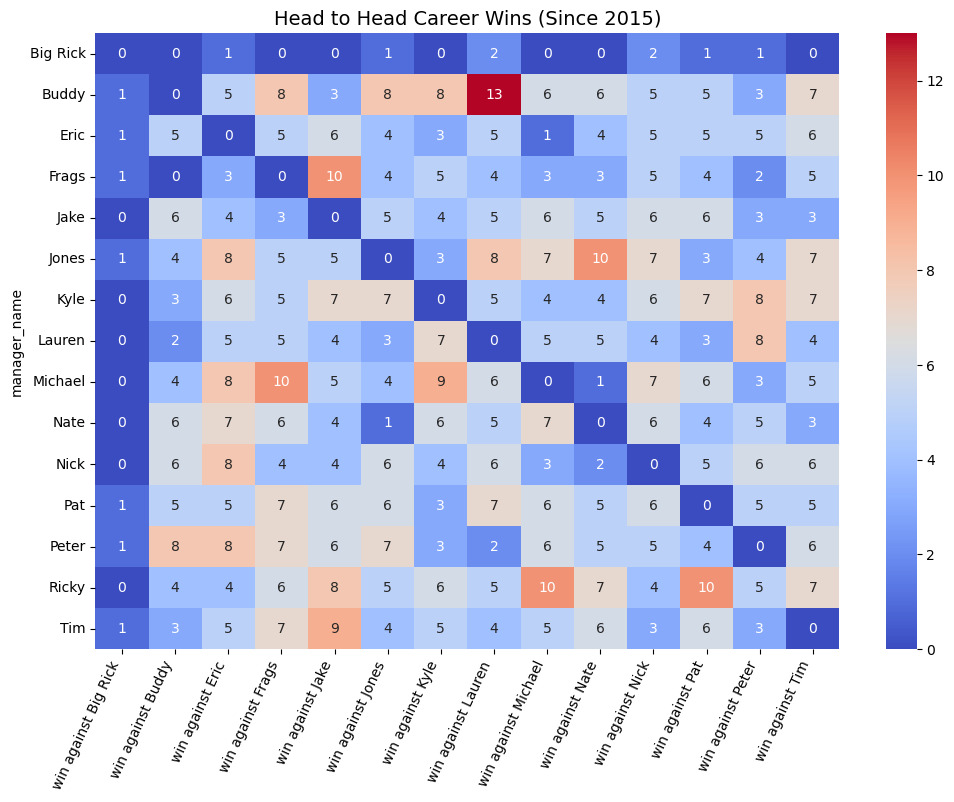

In [46]:
plt.figure(figsize=(12,8))
sns.heatmap(win_heatmap, cmap = 'coolwarm', annot=True)
plt.xticks(rotation=65, ha='right');
plt.title('Head to Head Career Wins (Since 2015)', size = 14);

In [47]:
df1 = pd.read_csv(data_dir1 + 'to_date_matchup_summaries_tidy.csv')

In [48]:
df2 = pd.read_csv(data_dir2 + 'matchup_player_data_through_2023.csv')
df2['season_week'] = df2['manager'] + '|' + df2['season'].astype(str) + '|' + df2['week'].astype(str)

In [49]:
df1.set_index('season_week', inplace= True)

In [50]:
df2.set_index('season_week', inplace= True)

In [51]:
df = df1.join(df2, how = 'left', rsuffix='_roster_data')

In [52]:
df_pre2021 = df[df['season'] < 2021].copy()
df_pre2021['playoff_week'] = np.where(df_pre2021['week'] >= 14, 1, 0)


In [53]:
df_2021on = df[df['season'] >= 2021].copy()
df_2021on['playoff_week'] = np.where(df_2021on['week'] >= 15, 1, 0)

In [54]:
df = pd.concat([df_pre2021, df_2021on])

In [55]:
@interact

def points_for_explorer( season = df['season'].unique()):

    pf_win_df = df[df['season'] == season][['team_name', 'points_for', 'win']].copy()
    median_winning = np.median(pf_win_df[pf_win_df['win'] == 1]['points_for'])
    median_losing = np.median(pf_win_df[pf_win_df['win'] == 0]['points_for'])
    fig = plt.figure(figsize=(8,8))
    plt.xlim(0, df['points_for'].max() )
    sns.kdeplot(pf_win_df[pf_win_df['win'] == 0], x = 'points_for', fill=True, label = 'Lost', color='goldenrod')
    sns.kdeplot(pf_win_df[pf_win_df['win'] == 1], x = 'points_for', fill=True, label = 'Won', color='blue')
    x, y = plt.gca().get_ylim()
    plt.vlines(median_losing, ymin=0, ymax= y, colors='darkorange', label='Median Losing Points')
    plt.vlines(median_winning , ymin=0, ymax= y, colors='navy', label='Median Winning Points')
    plt.legend()
    plt.show;
    bad_breaks = df[(df['points_for'] > median_winning) & (df['win'] == 0) & (df['season'] == season)][['manager','week','team_name', 'points_for', 'win', 'opponent_team_name']].copy()
    bad_breaks['note'] = 'Bad break!'
    lucky_breaks = df[(df['points_for'] < median_losing) & (df['win'] == 1) & (df['season'] == season)][['manager','week','team_name', 'points_for', 'win', 'opponent_team_name']].copy()
    lucky_breaks['note'] = 'Got lucky!'
    results_df = pd.concat([bad_breaks, lucky_breaks])
    return results_df

interactive(children=(Dropdown(description='season', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, …

In [56]:
managers = np.asarray('All')
managers = np.append(managers, df['manager'].unique())
sort_by_values = ['Mean Score', 'Score Standard Deviation', 'Lowest Score', 'Highest Score']
@interact 
def regular_season_points_for_fast_facts( season = df['season'].unique(), manager = managers, include_playoff = ['No','Yes'], sort = sort_by_values):
    
    playoff_mask = True if include_playoff == "Yes" else df['playoff_week'] == 0 
    if manager != 'All':
        filtered_df = df[(df['season'] == season) & (df['manager'] == manager) & (playoff_mask)]['points_for'].describe()
        filtered_df = pd.DataFrame(filtered_df)
        filtered_df = filtered_df.T
    else: 
        filtered_df = df[(df['season'] == season) & (playoff_mask)].groupby('manager')['points_for'].describe()
        
    filtered_df.rename({'count' : 'Weeks',
                       'mean' : 'Mean Score',
                       'std' : 'Score Standard Deviation',
                       'min': 'Lowest Score',
                       '25%': '25th Percentile',
                       '50%': '50th Percentile',
                       '75%' : '75th Percentile',
                       'max' : 'Highest Score'}, axis = 1, inplace = True)
    
    filtered_df.rename({'points_for' : 'Points For'}, inplace = True)
    if sort != 'Lowest Score':
        filtered_df = filtered_df.sort_values(sort, ascending = False)
    else:
        filtered_df = filtered_df.sort_values(sort, ascending = True)
    return filtered_df
    

interactive(children=(Dropdown(description='season', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, …

In [57]:
@interact
def highest_score_explorer( season = df['season'].unique()):
    '''
    Returns a dataframe of each manager's highest score for the season and shows that week's results
    '''
    max_df = pd.DataFrame(df[(df['season'] == season)].groupby('manager_name')['points_for'].max())
    losses_to_max = pd.DataFrame()
    for manager in max_df.index:
        manager_max = max_df.loc[manager, 'points_for'].item()
        season_df = df[df['season'] == season]
        relevant_row = season_df.loc[ df['points_for'] == manager_max, ['season', 'week', 'manager_name', 'points_for',  'win','opponent_name', 'points_against']]
        relevant_row['win'] = np.where(relevant_row['win'] == 1, 'Won', 'Lost')
        opponent = relevant_row['opponent_name']
        opponent_pts = relevant_row['points_against']
        relevant_row["was opponent's highest score"] = np.where(max_df.loc[opponent, 'points_for'].item() == opponent_pts, 'Yes', 'No')
        losses_to_max = pd.concat([losses_to_max, relevant_row], ignore_index= True)
    losses_to_max.rename({'manager_name' : 'manager',
                         'points_for' : 'scored',
                         'win' : 'result',
                         'opponent_name' : 'against',
                         'points_against': 'opponent scored'}, axis = 1, inplace = True)
    losses_to_max = losses_to_max.sort_values('scored', ascending=False)
    return losses_to_max

interactive(children=(Dropdown(description='season', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, …

In [58]:
position_columns = ['QB',
                   'WR1',
                   'WR2',
                   'WR3',
                   'RB1',
                   'RB2',
                   'TE',
                   'W/R/T',
                   'DEF',
                   'BN1',
                    'BN2',
                    'BN3',
                    'BN4',
                    'BN5',
                    'BN6',
                    'BN7'
                   ]
points_columns = [ x + '_points' for x in position_columns]    